# Week 3

**`Agent::pre-training::quadratic-programming`**
* **`optimizer`**: general objective function
* **`generator`**: supervised data generator
* **`QuadraticAgent`**: trading agent

In [1]:
# change current working directory
%cd ..

/Users/alpha/Developer/qtrader


In [2]:
# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# built-in containers
from collections import deque

# data provider
from qtrader.envs.data_loader import Finance
# pandas.DataFrame cleaner
from qtrader.utils.pandas import clean
# machine floating-point relative accuracy
from qtrader.utils.numpy import eps
# generate rolling data for a 2D array
from qtrader.utils import rolling2d
# trading environment
from qtrader.envs.trading import TradingEnv
# random trading agent
from qtrader.agents import RandomAgent

# YAML parser
import yaml

# scientific programming
import numpy as np
import scipy.optimize

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# fetch configuration file
config = yaml.load(open('config/log/week_3.yaml', 'r'))

# configuration summary
print(f"start date: {config['start_date']}")
print(f"trading frequency: {config['freq']}")
print(f"trading universe: {config['tickers']}")
print(f"rolling window size: {config['window']}")
print(f"transaction costs coefficient: {config['beta']}")

start date: 2015-01-01
trading frequency: W-FRI
trading universe: ['AAPL', 'GE', 'JPM', 'MSFT', 'VOD', 'GS', 'TSLA', 'MMM']
rolling window size: 20
transaction costs coefficient: 0.0025


### Data Source

Fetch prices, simple-relative returns and log-returns.

In [4]:
# prices
prices = clean(Finance.Prices(config['tickers'],
                              config['start_date'],
                              freq=config['freq'],
                              csv=config['csv_file_prices']))


# returns
returns = clean(Finance.Returns(config['tickers'],
                                config['start_date'],
                                freq=config['freq'],
                                csv=config['csv_file_returns']))

# log-returns
rhos = np.log(1 + returns)

### Empirical Estimators

First and second order moments empirical estimators and visualization.

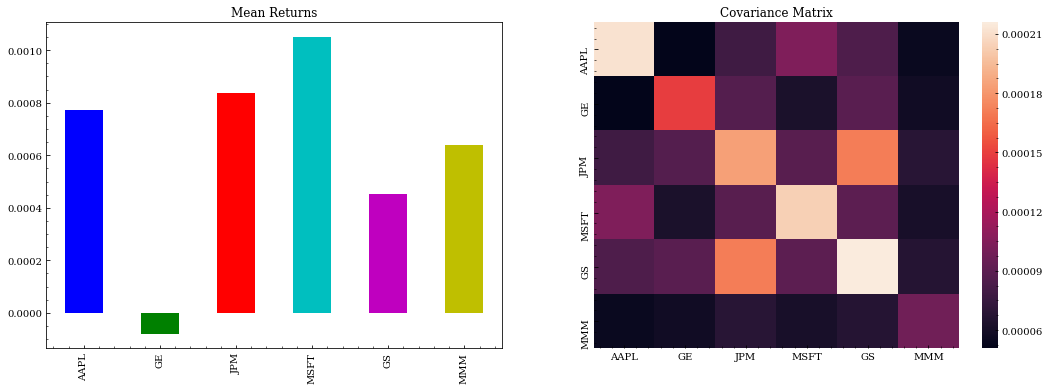

In [5]:
# mean returns
mu_r = returns.mean()
# returns covariance
Sigma_r = returns.cov()

fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))

mu_r.plot.bar(ax=axes[0])
axes[0].set_title('Mean Returns')

sns.heatmap(Sigma_r, ax=axes[1])
axes[1].set_title('Covariance Matrix');

## `optimizer`

General quadratic programming solver, accepting any objective
function $J$ to solve.

In [6]:
def optimizer(J, *args):
    """High-Order-Function receiving an objective
    function `J` and returning an quadratic
    programming solver."""
    def _optimizer(mu: np.ndarray, Sigma: np.ndarray,
                   w0: np.ndarray, short_sales: bool = True) -> np.ndarray:
        # number of assets
        M = mu.shape[0]
        # equality constraint: budget
        con_budget = {
            'type': 'eq',
            'fun': lambda w: np.sum(w) - 1.0
        }
        if short_sales:
            bounds = [(0, None) for _ in range(M)]
        else:
            bounds = [(None, None) for _ in range(M)]
        # execute
        results = scipy.optimize.minimize(
            J, w0, (mu, Sigma, w0, *args),
            constraints=(con_budget),
            bounds=bounds,
            method='SLSQP'
        )
        # handle errors
        if not results.success:
            raise BaseException(results.message)
        # optimal portfolio weights
        w = results.x
        return w
    return _optimizer

### Helper Functions

In [7]:
def _mu_p(w: np.ndarray, r: np.ndarray) -> float:
    """Portfolio Returns."""
    return np.dot(w.T, r)


def _sigma_p(w: np.ndarray, Sigma: np.ndarray) -> float:
    """Portoflio Variance"""
    return np.dot(np.dot(w.T, Sigma), w)


def _trans_costs(w: np.ndarray, w0: np.ndarray, coef: float) -> float:
    """Transaction Costs."""
    return np.sum(np.abs(w0 - w)) * coef

### $J_{1}$: Risk Averse Portfolio with Transaction Costs

Given $\alpha, \beta$, determine portfolio vector $\mathbf{w}$, such that:

\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \mathbf{w}^{T} \mathbf{r} -
    \alpha \mathbf{w}^{T} \boldsymbol{\Sigma} \mathbf{w} -
    \mathbf{1}^{T} \beta \|(\mathbf{w_{0}} - \mathbf{w})\|_{1} & \text{ (utility function) } \\
& \text{subject to}
& & \mathbf{w}^{T} \mathbf{1} = 1 & \text{ (budget constraint) } \\
&
& & 
\end{aligned}

where:

* $M$: number of assets in portfolio
* $\alpha \geq 0$: risk-aversion coefficient
* $\beta \geq 0$: transaction costs coefficient (i.e 0.0025)
* $\boldsymbol{\Sigma} \in \mathbb{R}^{M \times M}$: portfolio returns covariance
* $\mathbf{r} \in \mathbb{R}^{M}$: portfolio returns mean
* $\mathbf{w_{0}}$: initial portfolio weights

In [8]:
def risk_aversion(w: np.ndarray, mu: np.ndarray,
                  Sigma: np.ndarray, w0: np.ndarray,
                  alpha: float, beta: float) -> float:
    """Risk Aversion with Transaction Costs."""
    assert Sigma.shape[0] == Sigma.shape[1]
    assert mu.shape[0] == Sigma.shape[0]
    assert w.shape == w0.shape
    # mean - alpha * variance - transaction_costs
    return - (_mu_p(w, mu) - alpha * _sigma_p(w, Sigma) - _trans_costs(w, w0, beta))

In [9]:
# objective function
J_1 = risk_aversion

# uniform initial weights
w0 = np.ones_like(mu_r) / len(mu_r)

# range of alpha
alphas = np.linspace(0.001, 1000, 1000)

# caches
mus = np.empty_like(alphas)
sigmas = np.empty_like(alphas)
trans = np.empty_like(alphas)

# run experiments
for j, alpha in enumerate(alphas):
    # optimal weights
    wj = optimizer(J_1, alpha, config['beta'])(mu_r, Sigma_r, w0)
    # portfolio expected mean returns
    mus[j] = _mu_p(w=wj, r=mu_r)
    # portfolio expected variance
    sigmas[j] = _sigma_p(w=wj, Sigma=Sigma_r)
    # transaction costs
    trans[j] = _trans_costs(w=wj, coef=config['beta'], w0=w0)

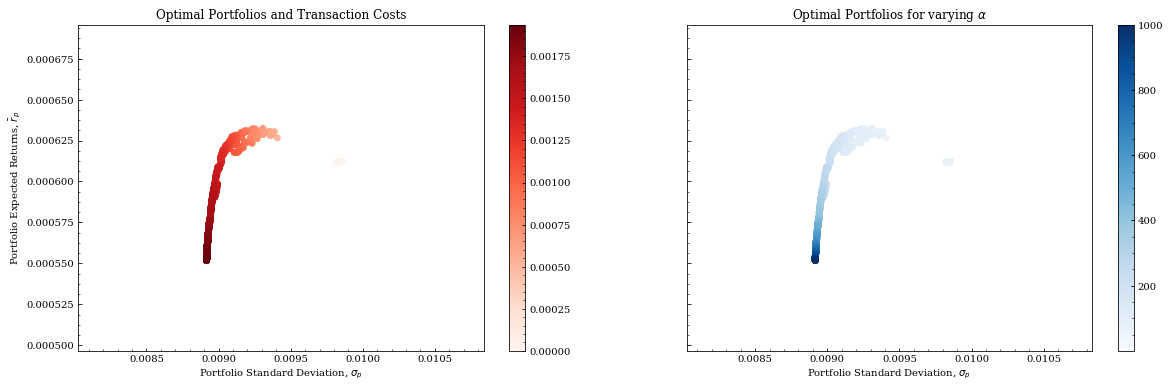

In [10]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(20.0, 6.0))
sc0 = axes[0].scatter(np.sqrt(sigmas), mus, c=trans, cmap=plt.cm.Reds)

axes[0].set_title('Optimal Portfolios and Transaction Costs')
axes[0].set_xlabel('Portfolio Standard Deviation, $\\sigma_{p}$')
axes[0].set_ylabel('Portfolio Expected Returns, $\\bar{r}_{p}$')
axes[0].set_ylim([mus.min() * 0.9, mus.max() * 1.1])
axes[0].set_xlim([np.sqrt(sigmas).min() * 0.9, np.sqrt(sigmas).max() * 1.1])
fig.colorbar(sc0, ax=axes[0])

sc1 = axes[1].scatter(np.sqrt(sigmas), mus, c=alphas, cmap=plt.cm.Blues)
axes[1].set_title('Optimal Portfolios for varying $\\alpha$')
axes[1].set_xlabel('Portfolio Standard Deviation, $\\sigma_{p}$')
axes[1].set_ylim([mus.min() * 0.9, mus.max() * 1.1])
axes[1].set_xlim([np.sqrt(sigmas).min() * 0.9, np.sqrt(sigmas).max() * 1.1])
fig.colorbar(sc1, ax=axes[1]);

## $J_{2}$: Tangency Portfolio with Transaction Costs

Given $\beta$, determine portfolio vector $\mathbf{w}$, such that:

\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \frac{\mathbf{w}^{T} \mathbf{r} - \mathbf{1}^{T} \beta \|(\mathbf{w_{0}} - \mathbf{w})\|_{1}}
        {\sqrt{\mathbf{w}^{T} \boldsymbol{\Sigma} \mathbf{w}}}
     & \text{ (utility function) } \\
& \text{subject to}
& & \mathbf{w}^{T} \mathbf{1} = 1 & \text{ (budget constraint) } \\
&
& & 
\end{aligned}

where:

* $M$: number of assets in portfolio
* $\beta \geq 0$: transaction costs coefficient (i.e 0.0025)
* $\boldsymbol{\Sigma} \in \mathbb{R}^{M \times M}$: portfolio returns covariance
* $\mathbf{r} \in \mathbb{R}^{M}$: portfolio returns mean
* $\mathbf{w_{0}}$: initial portfolio weights

In [11]:
def sharpe_ratio(w: np.ndarray, mu: np.ndarray,
                 Sigma: np.ndarray, w0: np.ndarray,
                 beta: float) -> float:
    """Sharpe Ratio with Transaction Costs."""
    assert Sigma.shape[0] == Sigma.shape[1]
    assert mu.shape[0] == Sigma.shape[0]
    assert w.shape == w0.shape
    # mean - alpha * variance - transaction_costs
    return - ((_mu_p(w, mu) - _trans_costs(w, w0, beta)) / (_sigma_p(w, Sigma) + eps))

In [12]:
# objective function
J_2 = sharpe_ratio

# uniform initial weights
w0 = np.ones_like(mu_r) / len(mu_r)

# range of alpha
alphas = np.linspace(0.001, 1000, 1000)

w = optimizer(J_2, config['beta'])(mu_r, Sigma_r, w0)
# portfolio expected mean returns
mu = _mu_p(w=w, r=mu_r)
# portfolio expected standard deviation
sigma = _sigma_p(w=w, Sigma=Sigma_r)
# transaction costs
trans = _trans_costs(w=w, coef=config['beta'], w0=w0)

print(f"expected mean returns: {mu}")
print(f"expected standard deviation: {sigma}")
print(f"transaction costs: {trans}")

expected mean returns: 0.000612153870384461
expected standard deviation: 9.708807167568885e-05
transaction costs: 3.33333360913457e-13


## `generator`

Provided an objective function $J$ and historic data, generate pairs
$\{\mathbf{x}_{i}, \mathbf{y}_{i}\}_{i=1}^{N}$ for pre-training
in a supervised learning manner.

In [13]:
def generator(num_samples, data, optimizer, window, short_sales=True):
    """Supervised data generator, following strategy
    determined by `optimizer`."""
    # input data shape
    N, M = data.shape
    # generated dataset
    X = np.empty((num_samples-window+1, window, M), dtype=float)
    y = np.zeros((num_samples-window+1, M), dtype=float)
    # iterate over rolling windows
    for i, frame in enumerate(rolling2d(data, window)):
        try:
            # empirical mean estimate
            mu_r = np.mean(frame, axis=0)
            # empirical covariance estimate
            Sigma_r = np.cov(data.T)
            # initial random weights
            w0 = np.random.uniform(0, 1.0, M)
            w0 = w0 / np.sum(w0)
            # observation
            X[i, :, :] = frame
            # optimal portfolio vector
            y[i, :] = optimizer(mu_r, Sigma_r, w0, short_sales)
        except BaseException as e:
            print("[i=%d]" % i, e)
    return X, y

In [14]:
# use tangency portfolio with transaction costs as objective function
optim = optimizer(J_2, config['beta'])
# create dataset
X, y = generator(len(returns), returns, optim, config['window'])
# verify validity of portfolio vectors
np.testing.assert_array_almost_equal(y.sum(axis=1), np.ones(y.shape[0]))
# dimensions
print(f"feature matrix shape: {X.shape}")
print(f"target matrix shape: {y.shape}")

feature matrix shape: (712, 20, 6)
target matrix shape: (712, 6)


## `QuadraticAgent`

Quadratic programming trading agent, provided an objective function $J$.
Folling API:
- `observe(observation, action, reward, done, next_observation)` -> `None`
- `act(observation)` -> `action: numpy.array`

In [15]:
class QuadraticAgent:
    """Quadratic Programming agent."""

    _id = 'quadratic'

    def __init__(self, action_space, J, window=10, *args):
        self.optimizer = optimizer(self._J(J), *args)
        self.action_space = action_space
        self.memory = deque(maxlen=window)
        # random initialization of weights
        self.w = self.action_space.sample()

    def observe(self, observation, action, reward, done, next_observation):
        self.memory.append(observation.values)

    def act(self, observation):
        # deque -> np.array, for easy math
        memory = np.array(self.memory)
        # number of assets
        M = len(observation)
        # expected returns vector
        mu = np.mean(memory, axis=0).reshape(M, 1)
        if len(self.memory) != self.memory.maxlen:
            sigma = np.eye(M)
        else:
            # empirical covariance matrix
            sigma = np.cov(memory.T)
        # quadratic programming portfolio solver
        try:
            self.w = self.optimizer(mu, sigma, self.w)
        except BaseException:
            pass
        return self.w

    @property
    def name(self):
        return self._id

    def _J(self, J):
        if J is "sharpe_ratio":
            return sharpe_ratio
        elif J is "risk_aversion":
            return risk_aversion

In [16]:
# reproduce results
np.random.seed(1)
# initialize trading environment
env = TradingEnv(prices=prices, trading_period=config['freq'])
# quadratic agent
tangent_agent = QuadraticAgent(env.action_space,
                               'sharpe_ratio',
                               config['window'],
                               config['beta'])
# random agent
random_agent = RandomAgent(env.action_space)
# register agents to environment
env.register(tangent_agent)
env.register(random_agent)
# reset environment
ob = env.reset()
ob = ob['returns']
reward = 0
done = False
while not done:
    # fill agent's memory
    tangent_agent.observe(ob, None, reward, done, None)
    # infer best actions
    tangent_action = tangent_agent.act(ob)
    random_action = random_agent.act(ob)
    # take actions
    ob, reward, done, _ = env.step({tangent_agent.name: tangent_action,
                                    random_agent.name: random_action})
    # discard other fields than 'returns'
    ob = ob['returns']
# returns
tangent_returns = env.agents[tangent_agent.name].rewards.sum(axis=1)
random_returns = env.agents[random_agent.name].rewards.sum(axis=1)
# compare PnLs
tangent_pnl = (tangent_returns + 1).cumprod().values[-1]
random_pnl = (random_returns + 1).cumprod().values[-1]
# compare Sharpe Ratios
tangent_sr = tangent_returns.mean() / (tangent_returns.std() + eps)
random_sr = random_returns.mean() / (random_returns.std() + eps)

tangent portfolio agent PnL: 1.3980475745087941
random agent PnL: 1.4305051614801945
tangent Sharpe Ratio: 0.16354693076507587
random Sharpe Ratio: 0.13121001319386433


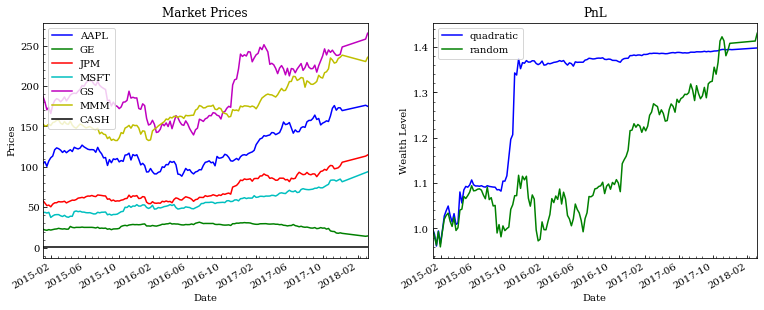

In [17]:
# agents PnL
print(f"tangent portfolio agent PnL: {tangent_pnl}")
print(f"random agent PnL: {random_pnl}")
# agents Sharpe Ratio
print(f"tangent Sharpe Ratio: {tangent_sr}")
print(f"random Sharpe Ratio: {random_sr}")
# visualize
env.render()